In [154]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.morphology import opening, disk
from skimage.transform import resize
from skimage import util
sns.set()
from tqdm import tqdm
plt.rcParams["axes.grid"] = False
import jax.numpy as jnp
import jax
from jax.scipy.ndimage import map_coordinates


In [155]:
class MassProfileSIE:
    def __init__(self, x_0, y_0, r_E, q):
        """
        Class to model lensing deflection field of SIE mass profile

        :param x_0: x-coordinate of center of deflector, in same units as r_E
        :param y_0: y-coordinate of center of deflector, in same units as r_E
        :param r_E: Einstein radius of deflector
        :param q: Axis-ratio of deflector
        """
        self.x_0 = x_0
        self.y_0 = y_0
        self.r_E = r_E
        self.q = q

    def deflection(self, x, y):
        """
        Calculate deflection vectors, from astro-ph/0102341

        :param x: x-coordinate at which deflection computed, in same units as r_E
        :param y: y-coordinate at which deflection computed, in same units as r_E
        :return: Deflections at positions specified by x, y
        """
        # Go into shifted coordinates
        x_p = x - self.x_0
        y_p = y - self.y_0
        
        # Compute deflection field
        xi = jnp.sqrt((self.q * x_p) ** 2 + y_p ** 2)

        x_d = jnp.where(self.q == 1., self.r_E * x_p / xi, self.r_E * self.q / jnp.sqrt(1 - self.q ** 2) * jnp.arctan(jnp.sqrt(1 - self.q ** 2) * x_p / xi))
        y_d = jnp.where(self.q == 1., self.r_E * y_p / xi, self.r_E * self.q / jnp.sqrt(1 - self.q ** 2) * jnp.arctanh(jnp.sqrt(1 - self.q ** 2) * y_p / xi))

        # Return deflection field
        return x_d, y_d

In [156]:
class MassProfileSIS:
    def __init__(self, x_0, y_0, r_E):
        """
        Class to model lensing deflection field of SIS mass profile

        :param x_0: x-coordinate of center of deflector, in same units as r_E
        :param y_0: y-coordinate of center of deflector, in same units as r_E
        :param r_E: Einstein radius of deflector
        """
        self.x_0 = x_0
        self.y_0 = y_0
        self.r_E = r_E

    def deflection(self, x, y):
        """
        Calculate deflection vectors, from astro-ph/0102341

        :param x: x-coordinate at which deflection computed, in same units as r_E
        :param y: y-coordinate at which deflection computed, in same units as r_E
        :return: Deflections at positions specified by x, y
        """
        # Go into shifted coordinates
        x_p = x - self.x_0
        y_p = y - self.y_0
        
        # Compute deflection field
        r = jnp.sqrt(x_p ** 2 + y_p ** 2)
        x_d = self.r_E * x_p / r
        y_d = self.r_E * y_p / r

        # Return deflection field
        return x_d, y_d

In [157]:
class MassProfileNFW:
    def __init__(self, x_0, y_0, r_s, rho_s):
        """
        Class to model lensing deflection field of NFW mass profile

        :param x_0: x-coordinate of center of deflector, in same units as r_s
        :param y_0: y-coordinate of center of deflector, in same units as r_s
        :param r_s: Scale radius of deflector
        :param rho_s: Characteristic density of deflector
        """
        self.x_0 = x_0
        self.y_0 = y_0
        self.r_s = r_s
        self.rho_s = rho_s

    def deflection(self, x, y):
        """
        Calculate deflection vectors, from arXiv:astro-ph/0102341

        :param x: x-coordinate at which deflection computed, in same units as r_s
        :param y: y-coordinate at which deflection computed, in same units as r_s
        :return: Deflections at positions specified by x, y
        """
        # Go into shifted coordinates
        x_p = x - self.x_0
        y_p = y - self.y_0

        # Compute deflection field
        R = np.sqrt(x_p**2 + y_p**2)
        theta = np.arctan2(y_p, x_p)

        F = np.zeros_like(R)
        G = np.zeros_like(R)
        mask = R > 0

        F[mask] = np.log(R[mask] / self.r_s) - (R[mask] / self.r_s) / (1 + R[mask] / self.r_s)
        G[mask] = 1 / (R[mask]**2 - self.r_s**2) * ((np.pi * self.rho_s * self.r_s**3) / 2) * (np.log(self.r_s / self.rho_s / R[mask] + 1) - np.log(self.r_s / self.rho_s))

        x_d = G * np.cos(theta)
        y_d = G * np.sin(theta)

        # Return deflection field
        return x_d, y_d


In [158]:
class LensingSim3D:
    def __init__(self, lenses_list=[{}], sources_list=[{}], observation_dict={}):
        """ Class for simulation of strong lensing images
        """

        self.lenses_list = lenses_list
        self.sources_list = sources_list

        self.observation_dict = observation_dict

        self.set_up_observation()


    def set_up_observation(self):
        """ Set up observational grid and parameters
        """
        
        # Coordinate limits (in arcsecs)
        self.theta_x_lims = self.observation_dict["theta_x_lims"]
        self.theta_y_lims = self.observation_dict["theta_y_lims"]

        # Size of grid
        self.n_x = self.observation_dict["n_x"]
        self.n_y = self.observation_dict["n_y"]

        # Exposure and background noise level
        self.exposure = self.observation_dict["exposure"]

        # x/y-coordinates of grid and pixel area in arcsec ** 2

        self.theta_x, self.theta_y = jnp.meshgrid(
            jnp.linspace(self.theta_x_lims[0], self.theta_x_lims[1], self.n_x),
            jnp.linspace(self.theta_y_lims[0], self.theta_y_lims[1], self.n_y)
        )

        self.pix_area = ((self.theta_x_lims[1] - self.theta_x_lims[0]) / self.n_x) * (
                    (self.theta_y_lims[1] - self.theta_y_lims[0]) / self.n_y)

    def lensed_image(self):
        """ Get strongly lensed image
        """

        # Get lensing potential gradients

        x_d, y_d = jnp.zeros((self.n_x, self.n_y)), jnp.zeros((self.n_x, self.n_y))

        for lens_dict in self.lenses_list:
            
            if lens_dict["profile"] == "SIE":
                _x_d, _y_d = MassProfileSIE(
                    x_0=lens_dict["theta_x_0"],
                    y_0=lens_dict["theta_y_0"],
                    r_E=lens_dict["theta_E"],
                    q=lens_dict["q"],
                ).deflection(self.theta_x, self.theta_y)
                
            elif lens_dict['profile'] == 'SIS':
                _x_d, _y_d = MassProfileSIS(
                    x_0=lens_dict["theta_x_0"],
                    y_0=lens_dict["theta_y_0"],
                    r_E=lens_dict["theta_E"],
                ).deflection(self.theta_x, self.theta_y)
                
            elif lens_dict['profile'] == 'NFW':
                _x_d, _y_d = MassProfileNFW(
                    x_0=lens_dict["theta_x_0"],
                    y_0=lens_dict["theta_y_0"],
                    r_s=lens_dict["r_s"],
                    rho_s=lens_dict["rho_s"],
                ).deflection(self.theta_x, self.theta_y)
                
            else:
                raise Exception("Unknown lens profile specification!")

            x_d += _x_d
            y_d += _y_d
            
        # Evaluate source image on deflected lens plane to get lensed image

        f_lens = jnp.zeros((self.n_x, self.n_y, 3))

        for source_dict in self.sources_list:
            
            src_ary = source_dict["src_ary"]
            for ch in range(3):
                f_lens = f_lens.at[:, :, ch].add(self.grid_interp(limits=[self.theta_x_lims, self.theta_y_lims], values=src_ary[:, :, ch], coords=(self.theta_x - x_d, self.theta_y - y_d)))

        i_tot = f_lens * self.exposure * self.pix_area  # Total lensed image

        return i_tot

    def grid_interp(self, limits, values, coords):
        coords = jnp.broadcast_arrays(*coords)
        coords = [(c - lo) * (n - 1) / (hi - lo) for (lo, hi), c, n in zip(limits, coords, values.shape)]
        values = jnp.where(jnp.isnan(values), -9999, values)  # Replace NaN with -9999
        return map_coordinates(values, coords, mode="constant", cval=-9999, order=1)

    @staticmethod
    def _mag_to_flux(mag, mag_zp):
        """Returns total flux of the integrated profile corresponding to magnitude `mag`, in ADU relative to `mag_zp`"""
        # For grayscale images
        if len(mag.shape) == 2:
            return 10 ** (-0.4 * (mag - mag_zp))
        # For color images
        elif len(mag.shape) == 3:
            flux = jnp.zeros(mag.shape[:-1])
            for i in range(mag.shape[2]):
                flux += 10 ** (-0.4 * (mag[:, :, i] - mag_zp[i]))
            return flux
        else:
            raise ValueError("Invalid image shape")

In [159]:
filename = "../../data/Galaxy10_DECals.h5"

with h5py.File(filename, "r") as f:

    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    ra = f['ra'][()]
    dec = f['dec'][()]
    z = f['redshift'][()]
    label = f['ans'][()]
    images = f['images'][()]

Keys: <KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>


(256, 256, 3) uint8 255


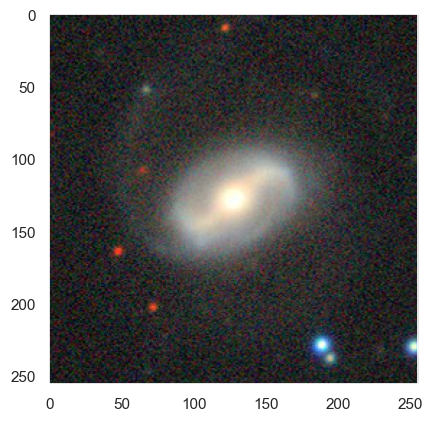

In [8]:
img = images[100]
print(img.shape, img.dtype, max(img.flatten()))
plt.imshow(img);

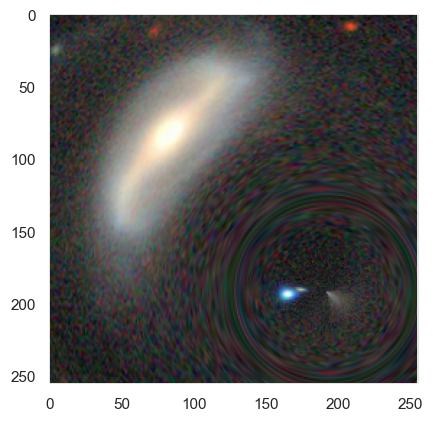

In [160]:
n_xy = 256  # Number of pixels to a side in the image
coordinate_limits = 1.  # Limits of the lensed image in arcseconds

# Lens parameters
lens_dict = {"profile": "SIS", "theta_x_0": .5, "theta_y_0": .5, "theta_E": .5, "q": 1}

# Observation configuration
observation_dict = {"theta_x_lims": [-coordinate_limits, coordinate_limits], "theta_y_lims": [-coordinate_limits, coordinate_limits], "n_x":n_xy, "n_y":n_xy, "exposure":1e8}

lensing_sim = LensingSim3D(lenses_list=[lens_dict], sources_list=[{"src_ary":img}], observation_dict=observation_dict)
# Create lensed image, including Poisson noise
lensed_image = (np.random.poisson(lensing_sim.lensed_image()))
lensed_image = (lensed_image * 255.0 / np.max(lensed_image)).astype(np.uint8)
plt.imshow(lensed_image)

In [216]:
## generate random values between 0 and 0.5
np.random.seed(42)
xs = np.random.rand(len(images)) * 0.5
ys = np.random.rand(len(images)) * 0.5
theta_Es = np.random.rand(len(images)) * 0.5
qs = np.random.rand(len(images))

In [217]:
lens_params = {"theta_x_0": xs, 
             "theta_y_0": ys, 
             "theta_E": theta_Es, 
             "q": qs}

In [218]:
def save_in_h5py(f, images, lensed_images, lens_params_list, labels):
    images = f.create_dataset(
        "original_images", np.shape(images), data=images, compression='gzip', chunks=True)
    lensed_images = f.create_dataset(
        "lensed_images", np.shape(lensed_images), data=lensed_images, compression='gzip', chunks=True)
    labels = f.create_dataset(
        "labels", np.shape(labels), data=labels,  compression='gzip', chunks=True)
    lens_params_list = f.create_dataset(
        "lens_params_list", len(lens_params_list), data=lens_params_list, compression='gzip', chunks=True)

In [221]:
from typing import List, Dict, Tuple

'''
SIE == 0
SIS == 1
NFW == 2
'''

def lens_images(images: List[np.ndarray], lens_params: Dict[str, List[float]], profile: str = "SIE") -> Tuple[List[Dict[str, float]], List[np.ndarray]]:
    
    '''
    Mass Profiles:
    
    SIE == 0
    SIS == 1
    NFW == 2
    '''

    n_xy = 256  # Number of pixels to a side in the image
    coordinate_limits = 1.  # Limits of the lensed image in arcseconds

    observation_dict = {"theta_x_lims": [-coordinate_limits, coordinate_limits], "theta_y_lims": [-coordinate_limits, coordinate_limits], "n_x":n_xy, "n_y":n_xy, "exposure":1e8}

    lensed_images = []
    lens_params_list = []
    for i in range(len(images)):
        
        if profile == "SIE":
            profile_idx = 0
        elif profile == "SIS":
            profile_idx = 1
        elif profile == 'NFW':
            profile_idx = 2
            
        lens_dict = {"profile": profile, "theta_x_0": lens_params["theta_x_0"][i], "theta_y_0": lens_params["theta_y_0"][i], "theta_E": lens_params["theta_E"][i], "q": lens_params["q"][i]}
        lensing_sim = LensingSim3D(lenses_list=[lens_dict], sources_list=[{"src_ary":images[i]}], observation_dict=observation_dict)
        lensed_image = np.random.poisson(lensing_sim.lensed_image())
        lensed_image = (lensed_image * 255.0 / np.max(lensed_image)).astype(np.uint8)
        lensed_images.append(lensed_image)
        lens_dict = {"profile": profile_idx, "theta_x_0": lens_params["theta_x_0"][i], "theta_y_0": lens_params["theta_y_0"][i], "theta_E": lens_params["theta_E"][i], "q": lens_params["q"][i]}
        lens_params_list.append(lens_dict)
        
    return np.asarray(lens_params_list), np.asarray(lensed_images)

In [222]:
lens_params_list, lensed_images = lens_images(images, lens_params, profile='SIS')

In [226]:
dt = np.dtype([
    ('profile', np.int32),
    ('theta_x_0', np.float64),
    ('theta_y_0', np.float64),
    ('theta_E', np.float64),
    ('q', np.float64)])

# Convert the numpy array to the structured data type
data_structured = np.zeros(lens_params_list.shape, dtype=dt)
for field in dt.names:
    data_structured[field] = [d[field] for d in lens_params_list]

lens_params_list = data_structured

In [230]:
f = h5py.File('../../data/lensing_dataset_SIS.h5','w')
save_in_h5py(f, images=images, lensed_images=lensed_images, lens_params_list=lens_params_list, labels=label)
f.close()